In [3]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

In [4]:
model

DepthAnythingForDepthEstimation(
  (backbone): Dinov2Backbone(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplac

In [10]:
with torch.no_grad():
    outputs = model(**inputs)

In [11]:
outputs['predicted_depth'].shape

torch.Size([1, 518, 686])

In [12]:
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

In [13]:
predicted_depth = post_processed_output[0]["predicted_depth"]
depth = predicted_depth * 255 / predicted_depth.max()
depth = depth.detach().cpu().numpy()
depth = Image.fromarray(depth.astype("uint8"))

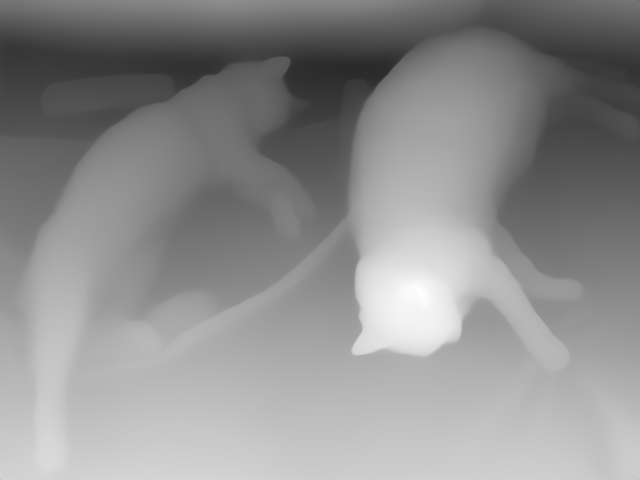

In [14]:
depth

In [15]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

In [16]:
model.backbone.layernorm.register_forward_hook(get_activation('backbone_output'))

In [17]:
for i in range(4):
    model.neck.reassemble_stage.layers[i].resize.register_forward_hook(
        get_activation(f'reassemble_stage_{i}')
    )

In [18]:
model.neck.fusion_stage.layers[-1].register_forward_hook(get_activation('fusion_output'))

# 4. Final embeddings before depth prediction
model.head.conv2.register_forward_hook(get_activation('final_embedding'))

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

In [19]:
print("Available embeddings:")
for name, tensor in activation.items():
    if isinstance(tensor, tuple):
        print(f"{name}: tuple of length {len(tensor)}")
        for i, t in enumerate(tensor):
            if isinstance(t, torch.Tensor):
                print(f"  - Element {i}: shape {t.shape}")
    elif isinstance(tensor, torch.Tensor):
        print(f"{name}: tensor of shape {tensor.shape}")
    else:
        print(f"{name}: {type(tensor)}")

Available embeddings:
backbone_output: tensor of shape torch.Size([1, 1814, 1024])
reassemble_stage_0: tensor of shape torch.Size([1, 256, 148, 196])
reassemble_stage_1: tensor of shape torch.Size([1, 512, 74, 98])
reassemble_stage_2: tensor of shape torch.Size([1, 1024, 37, 49])
reassemble_stage_3: tensor of shape torch.Size([1, 1024, 19, 25])
fusion_output: tensor of shape torch.Size([1, 256, 296, 392])
final_embedding: tensor of shape torch.Size([1, 32, 518, 686])


In [20]:
fusion_embedding = activation['fusion_output']
if isinstance(fusion_embedding, tuple):
    fusion_embedding = fusion_embedding[0]  # Take the first element if it's a tuple

# Convert to numpy for easier handling
fusion_embedding_np = fusion_embedding.cpu().numpy()
print(f"Fusion embedding shape: {fusion_embedding_np.shape}")

Fusion embedding shape: (1, 256, 296, 392)


In [21]:
if len(fusion_embedding_np.shape) == 4:  # [batch, channels, height, width]
    embedding_vis = np.mean(fusion_embedding_np, axis=1)[0]  # Take the first image in batch
    embedding_vis = (embedding_vis - embedding_vis.min()) / (embedding_vis.max() - embedding_vis.min()) * 255
    embedding_vis = embedding_vis.astype(np.uint8)
    embedding_image = Image.fromarray(embedding_vis)
    embedding_image.save('embedding_visualization.png')

In [22]:
def get_depth_embedding_vectors(embedding_tensor, method="global", regions=None, points=None):
    """
    Extract useful vector representations from depth embeddings
    
    Args:
        embedding_tensor: Tensor of shape [batch, channels, height, width]
        method: One of "global", "pixels", "regions", or "points"
        regions: List of [y1, x1, y2, x2] coordinates for region extraction
        points: List of [y, x] coordinates for point extraction
        
    Returns:
        Embedding vectors in the requested format
    """
    # Ensure tensor is on CPU and convert to numpy
    if isinstance(embedding_tensor, torch.Tensor):
        embedding_np = embedding_tensor.cpu().numpy()
    else:
        embedding_np = embedding_tensor
    
    batch, channels, height, width = embedding_np.shape
    
    # 1. Global vector (average pooling across spatial dimensions)
    if method == "global":
        # Average across spatial dimensions for each channel
        global_vector = np.mean(embedding_np, axis=(2, 3))  # Shape: [batch, channels]
        return global_vector
    
    # 2. Per-pixel vectors (reshape to have one vector per pixel)
    elif method == "pixels":
        # Reshape to [batch, height*width, channels]
        pixel_vectors = np.transpose(embedding_np, (0, 2, 3, 1))  # [batch, height, width, channels]
        pixel_vectors = pixel_vectors.reshape(batch, height*width, channels)
        return pixel_vectors
    
    # 3. Region-based vectors (extract and pool vectors from specific regions)
    elif method == "regions" and regions is not None:
        region_vectors = []
        for region in regions:
            y1, x1, y2, x2 = region
            # Ensure coordinates are within bounds
            y1, y2 = max(0, y1), min(height, y2)
            x1, x2 = max(0, x1), min(width, x2)
            
            if y1 >= y2 or x1 >= x2:
                continue  # Skip invalid regions
            
            # Extract region and average pool
            region_data = embedding_np[:, :, y1:y2, x1:x2]
            region_vector = np.mean(region_data, axis=(2, 3))  # [batch, channels]
            region_vectors.append(region_vector)
        
        return np.array(region_vectors).squeeze(1) if region_vectors else None
    
    # 4. Point-based vectors (extract vectors at specific points)
    elif method == "points" and points is not None:
        point_vectors = []
        for point in points:
            y, x = point
            # Ensure coordinates are within bounds
            if 0 <= y < height and 0 <= x < width:
                # Extract vector at point [y, x]
                point_vector = embedding_np[:, :, y, x]  # [batch, channels]
                point_vectors.append(point_vector)
        
        return np.array(point_vectors).squeeze(1) if point_vectors else None
    
    return None

In [23]:
fusion_tensor = activation['fusion_output']

In [25]:
fusion_tensor.shape

torch.Size([1, 256, 296, 392])

In [ ]:
global_vector = get_depth_embedding_vectors(fusion_tensor, method="global")

In [27]:
print(f"Global vector shape: {global_vector.shape}")

Global vector shape: (1, 256)
